# Advanced: Differential Evolution Optimizer

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger('error')

## Create fake "observations"

We'll create the same fake "observations" as in the [Inverse Paper Examples](../examples/inverse_paper_examples.ipynb).

For the sake of efficiency for this example, we'll only use an RV dataset with `rv_method='dynamical'`, and omit the LC dataset which is more computationally expensive.  

In [3]:
b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('rv', compute_times=rvtimes)
b.set_value_all('rv_method', 'dynamical')
b.run_compute()

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 17046.06it/s]


In [4]:
b = phoebe.default_binary()

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.set_value_all('rv_method', 'dynamical')

We'll set the initial model to be *close* to the correct values, but not exact.  In practice, we would instead have to use a combination of manual tweaking, and [RV_estimators](./RV_estimators.ipynb) to get in the rough parameter space of the solution before starting to use optimizers.

In [5]:
b.set_value('sma@binary', 7+0.5)
b.set_value('incl@binary', 80+10)
b.set_value('q', 0.3+0.1)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0-0.3)

In [6]:
b.run_compute(model='orig_model')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 19603.65it/s]


<ParameterSet: 5 parameters | components: primary, secondary>

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


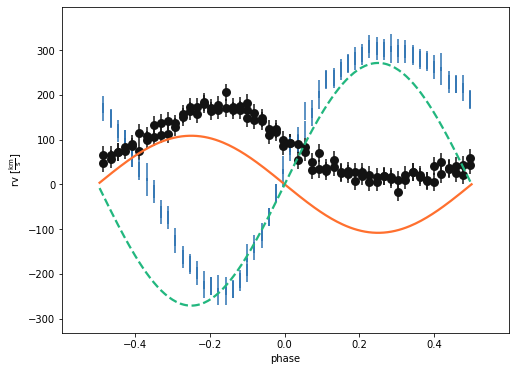

In [7]:
_ = b.plot(x='phases', show=True)

## Differential Evolution Options

As with any solver, we call [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and this time pass [optimizer.differential_evolution](../api/phoebe.parameters.solver.optimizer.differential_evolution.md).

In [8]:
b.add_solver('optimizer.differential_evolution', solver='de_solver')

<ParameterSet: 16 parameters | qualifiers: comments, expose_lnprobabilities, bounds, recombination, strategy, polish, atol, fit_parameters, popsize, bounds_sigma, tol, compute, use_server, maxiter, bounds_combine, progress_every_niters>

This adds new parameters to our bundle with the options for running differential evolution.

In [9]:
print(b.filter(solver='de_solver'))

ParameterSet: 14 parameters
        comments@de_solver@solver: 
      use_server@de_solver@solver: compute
         compute@de_solver@solver: phoebe01
   expose_lnprobabilities@de_s...: False
   fit_parameters@de_solver@so...: []
          bounds@de_solver@solver: []
        strategy@de_solver@solver: best1bin
         maxiter@de_solver@solver: 1000000
         popsize@de_solver@solver: 8
   recombination@de_solver@solver: 0.7
             tol@de_solver@solver: 0.01
            atol@de_solver@solver: 0.0
          polish@de_solver@solver: True
   progress_every_niters@de_so...: 0


We can see that the set of parameters for differential evolution partially differs from the ones we see in the local optimizers. For more explanation of what each one does see the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html). For the purposes of this tutorial, let's only set `maxiter` to a lower value:

In [11]:
b.set_value('maxiter', 500)

One notable difference between differential evolution and the local optimizers available in PHOEBE is the lack of an `initial_values` parameter, while instead we have a `bounds` parameter. The reason for that is the inherent difference between how these optimizers work: local optimizers start from a single value, while differential evolution initializes a number of initial points (set by default as popsize * number of fitted parameters) within the provided bounds.

Let's then choose the parameters to fit and set their bounds:

In [12]:
b.set_value('fit_parameters', ['q', 'sma@binary', 'ecc', 'per0', 'vgamma', 't0_supconj'])

In [13]:
print(b.get_parameter('bounds'))

Parameter: bounds@de_solver@solver
                       Qualifier: bounds
                     Description: distribution(s) to use for bounds.  For any non-uniform distributions, bounds will be adopted based on the bounds_sigma parameter.  Only those in fit_parameters will be considered.  Any in fit_parameters but not in bounds will use the limits on the parameter itself as bounds.  Any covariances will be ignored.
                           Value: []
                         Choices: 
                  Constrained by: 
                      Constrains: None
                      Related to: None



As we can see, the bounds parameter expects uniform distributions for each parameter. If not provided, the default parameter limits will be used, which can be None or too wide, so it's more optimal to provide our own:

In [14]:
b.add_distribution('q', phoebe.uniform(0.1,0.5), distribution='de_bounds')
b.add_distribution('sma@binary', phoebe.uniform(5,10), distribution='de_bounds')
b.add_distribution('ecc', phoebe.uniform(0,0.4), distribution='de_bounds')
b.add_distribution('per0', phoebe.uniform(0,50), distribution='de_bounds')
b.add_distribution('vgamma', phoebe.uniform(50,100), distribution='de_bounds')
b.add_distribution('t0_supconj', phoebe.uniform(0,0.2), distribution='de_bounds')

<ParameterSet: 1 parameters>

In [15]:
b.set_value('bounds@de_solver', ['de_bounds',])

In [16]:
print(b['de_solver'])

ParameterSet: 15 parameters
        comments@de_solver@solver: 
      use_server@de_solver@solver: compute
         compute@de_solver@solver: phoebe01
   expose_lnprobabilities@de_s...: False
   fit_parameters@de_solver@so...: ['q', 'sma@binary', 'ecc', 'per0', 'vgamma', 't0_supconj']
          bounds@de_solver@solver: ['de_bounds']
    bounds_sigma@de_solver@solver: 3.0
        strategy@de_solver@solver: best1bin
         maxiter@de_solver@solver: 500
         popsize@de_solver@solver: 8
   recombination@de_solver@solver: 0.7
             tol@de_solver@solver: 0.01
            atol@de_solver@solver: 0.0
          polish@de_solver@solver: True
   progress_every_niters@de_so...: 0


We can now run the solver. Depending on the number of parameters and type of dataset, this may take significantly longer than running a local optimizer, so it is often useful to offload it to a high-performance cluster, if available.

In [17]:
b.run_solver('de_solver')

  3%|████                                                                                                                  | 17/500 [32:59<15:37:19, 116.44s/it]


<ParameterSet: 11 parameters | qualifiers: bounds, comments, fitted_units, fitted_values, message, niter, adopt_values, success, adopt_parameters, adopt_distributions, fitted_twigs>

We can see that even though we set the maximum number of iteration to 500, the solver stopped after only 17 because the tolerance condition was met first!

As usual, after the solver is done, we can adopt the solution, run compute and plot the results to verify that the optimizer did its job!

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


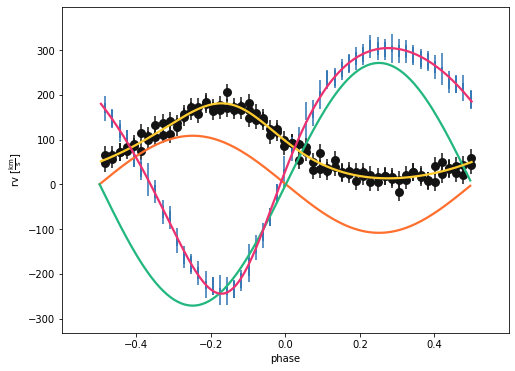

In [18]:
b.adopt_solution()
b.run_compute(model='after_de')
_ = b.plot(x='phases', 
           linestyle={'model': 'solid'},
           color={'after_de': 'red', 'orig_model': 'green'},
           show=True)